In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
import joblib


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Final Project/DataSet/thinking.csv')

X = df[['F3', 'FC5', 'AF3', 'F7', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'F8', 'AF4', 'FC6', 'F4']]
y = df['Label']


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)


X_train_normalized = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test_normalized = (X_test - X_test.min()) / (X_test.max() - X_test.min())

In [ ]:
X_train_nn = np.expand_dims(X_train_normalized.values, axis=1)
X_test_nn = np.expand_dims(X_test_normalized.values, axis=1)

class_weights = compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

lstm_model = Sequential([
    Input(shape=(X_train_nn.shape[1], X_train_nn.shape[2])),
    Bidirectional(LSTM(64, activation='tanh', return_sequences=False)),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax') 
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = lstm_model.fit(X_train_nn, y_train, epochs=50, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

y_pred_proba = lstm_model.predict(X_test_nn)
y_pred = np.argmax(y_pred_proba, axis=1)

Epoch 1/50
10752/10752 ━━━━━━━━━━━━━━━━━━━━ 63s 5ms/step - accuracy: 0.0631 - loss: 2.7735 - val_accuracy: 0.0669 - val_loss: 2.7726
Epoch 2/50
10752/10752 ━━━━━━━━━━━━━━━━━━━━ 61s 6ms/step - accuracy: 0.0632 - loss: 2.7727 - val_accuracy: 0.0637 - val_loss: 2.7722
Epoch 3/50
10752/10752 ━━━━━━━━━━━━━━━━━━━━ 77s 5ms/step - accuracy: 0.0656 - loss: 2.7720 - val_accuracy: 0.0684 - val_loss: 2.7706
Epoch 4/50
10752/10752 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - accuracy: 0.0659 - loss: 2.7710 - val_accuracy: 0.0675 - val_loss: 2.7691
Epoch 5/50
10752/10752 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - accuracy: 0.0668 - loss: 2.7702 - val_accuracy: 0.0753 - val_loss: 2.7715
Epoch 6/50
10752/10752 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - accuracy: 0.0685 - loss: 2.7693 - val_accuracy: 0.0697 - val_loss: 2.7676
Epoch 7/50
10752/10752 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - accuracy: 0.0703 - loss: 2.7684 - val_accuracy: 0.0758 - val_loss: 2.7665
Epoch 8/50
10752/10752 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.07384440104166666
Precision: 0.4266300324656222
Recall: 0.07384440104166666
F1 Score: 0.028621301317867144


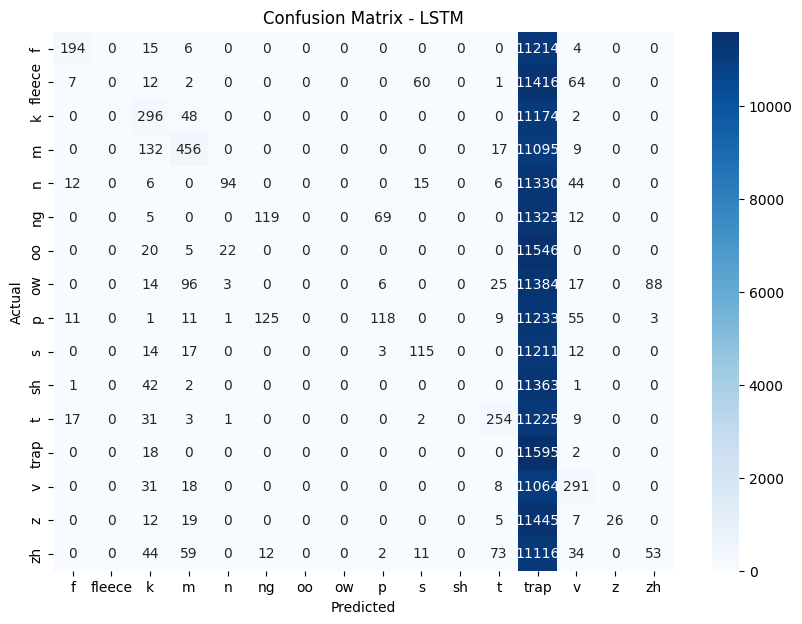

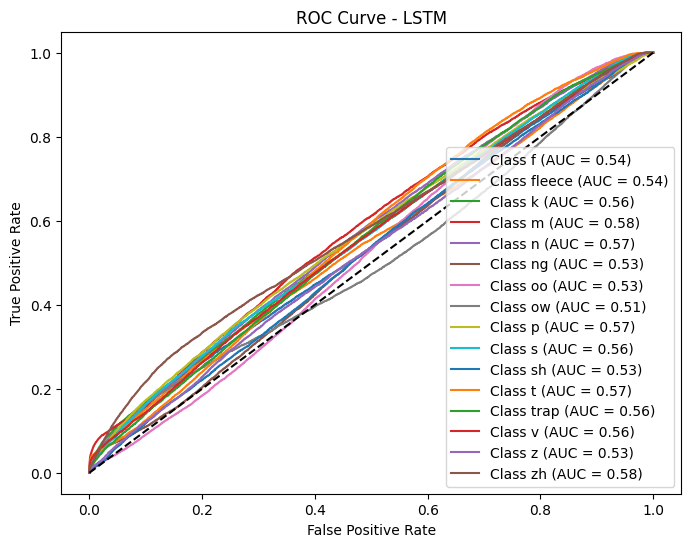

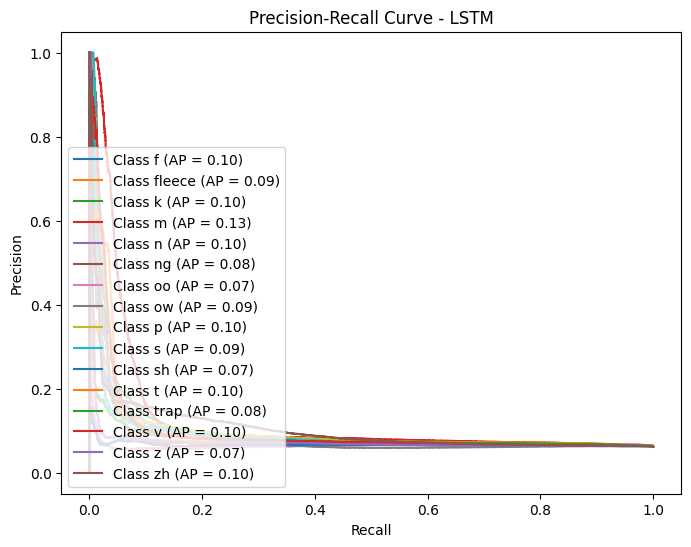

Metrics saved as 'lstm_metrics.txt'
LSTM model saved as 'lstm_model.h5'


In [5]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion Matrix Plot
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LSTM")
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title("ROC Curve - LSTM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve((y_test == i).astype(int), y_pred_proba[:, i])
    avg_precision = average_precision_score((y_test == i).astype(int), y_pred_proba[:, i])
    plt.plot(recall, precision, label=f"Class {label_encoder.classes_[i]} (AP = {avg_precision:.2f})")

plt.title("Precision-Recall Curve - LSTM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

# Save metrics to a text file
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Confusion Matrix": conf_matrix.tolist()  # Convert numpy array to list for saving
}

with open('lstm_metrics.txt', 'w') as f:
    f.write("LSTM Model Metrics\n")
    f.write("==================\n")
    for key, value in metrics.items():
        if key == "Confusion Matrix":
            f.write(f"{key}:\n")
            for row in value:
                f.write(f"{row}\n")
        else:
            f.write(f"{key}: {value}\n")

print("Metrics saved as 'lstm_metrics.txt'")

# Save the trained model
lstm_model.save('lstm_model.h5')
print("LSTM model saved as 'lstm_model.h5'")
